In [1]:
# ### task
#  - считывать картинку + ближайшую точку на соотв disparity map

# - выделить маску

# ### Data description

### Imports

In [1]:
import cv2
import glob
import os
import sys
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 2

#### Reading

In [3]:
path_data = '/home/anastasia/obj_detection/data/cityscapes/disparity'
print os.path.abspath(path_data)

/home/anastasia/obj_detection/data/cityscapes/disparity


In [15]:
# paths 
cityscapesPath = os.path.normpath(os.path.join(os.path.dirname('__file__'), '..', 'data/cityscapes'))
img_dir = 'leftImg8bit'
path_left_imgs = os.path.normpath(os.path.join(cityscapesPath,img_dir))

# default dictionary of cities
cities = defaultdict(list)
modes = ['train','test','val']
for mode in modes:
    for (dirpath, dirnames, filenames) in os.walk(path_left_imgs+'/'+mode):
        cities[mode] = dirnames 
        break
        
mode = 'train'
city = 'zurich'


# returns list of paths to imgs for this city
def read_imgs(mode=mode, city=city):
    
    # absolute path to the directory with images
    path_imgs = os.path.normpath(os.path.join(cityscapesPath,img_dir, mode, city))
    # list of absolute paths to images
    imgs = glob.glob(path_imgs + '/*.png')
    imgs.sort()
    
    print 'read_imgs.','%s %s: number of images is' %(mode,city), len(imgs)
    
    return imgs


# returns list of paths to disparity imgs for this city
def read_disparities(mode=mode, city=city):
    
    # absolute path to the directory with disparities
    path_disp = os.path.normpath(os.path.join(cityscapesPath,'disparity', mode, city))
    # list of absolute paths to disparities
    disp_imgs = glob.glob(path_disp + '/*.png')
    disp_imgs.sort()
    
    print 'read_disparities.', '%s %s: number of disparity images is' %(mode,city), len(disp_imgs)
    
    
    return disp_imgs


def find_disparity(img_path, mode=mode, city=city):
    
    path_disp = os.path.normpath(os.path.join(cityscapesPath,'disparity', mode, city))
    
    # take a tail of img path
    img_name = os.path.split(img_path)[1]
    # remove extention
    img_name = os.path.splitext(img_name)[0]
    # take img number
    img_number = img_name[:-len(img_dir)]
    # abs path to the corresponded disparity
    disp_path = glob.glob(path_disp +'/'+ str(img_number)+'*')[0]
    
    return disp_path
    
def max_disp(disp_path, mode=mode, city=city):
    
    disp = cv2.imread(disp_path)
    
    return np.max(disp[np.nonzero(disp)])



## Test

In [16]:
imgs = read_imgs()
disp_imgs = read_disparities()

print disp_imgs[0]

filename = os.path.split(imgs[0])[1]
name = os.path.splitext(filename)[0][:-len(img_dir)]
print name

disp = cv2.imread(find_disparity(imgs[0]))
print np.max(disp[np.nonzero(disp)])

read_imgs. train zurich: number of images is 122
read_disparities. train zurich: number of disparity images is 122
../data/cityscapes/disparity/train/zurich/zurich_000000_000019_disparity.png
zurich_000000_000019_
116


image index in list imgs: 12
max disparity: 126


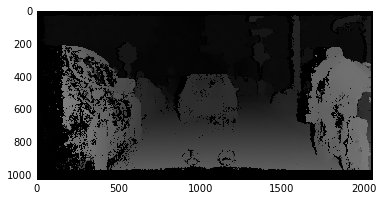

In [39]:
# good example nmb_image = 41, 12

nmb_img = 12 #np.random.randint(0,len(disp_imgs))
print 'image index in list imgs:', nmb_img

# print disp.shape
# print disp_imgs[nmb_img]
# print imgs[nmb_img]

disp = cv2.imread(disp_imgs[nmb_img])
img = cv2.imread(imgs[nmb_img])

print 'max disparity:', disp.max()
plt.imshow(disp)

#### Disparities in the percentile

126


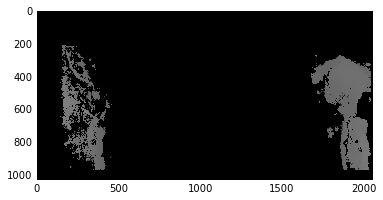

In [40]:
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
print disp.max()
plt.imshow(disp_perc)

#### Image's pixels correspondes to disparity in the percentile

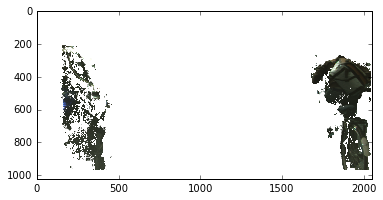

In [42]:
img_perc = img.copy()
img_perc[disp < np.percentile(disp, 90)] = 255
plt.imshow(img_perc)

#### Histogram of max disparties for this city

In [46]:
max_disps = []
print len(disp_imgs)
for i in range (len(disp_imgs)):
    max_disps.append(max_disp(disp_imgs[i]))


221


(array([   1.,    1.,    1.,    0.,    0.,    1.,    2.,    0.,    1.,
           1.,    1.,    2.,    4.,    3.,    1.,    3.,    4.,    5.,
           9.,    7.,   13.,    8.,   15.,   16.,  122.]),
 array([  97.  ,   98.16,   99.32,  100.48,  101.64,  102.8 ,  103.96,
         105.12,  106.28,  107.44,  108.6 ,  109.76,  110.92,  112.08,
         113.24,  114.4 ,  115.56,  116.72,  117.88,  119.04,  120.2 ,
         121.36,  122.52,  123.68,  124.84,  126.  ]),
 <a list of 25 Patch objects>)

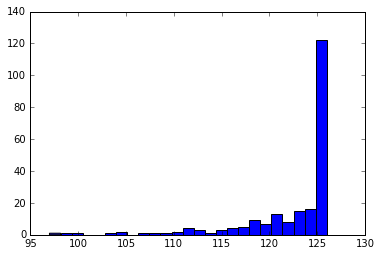

In [47]:
plt.hist(max_disps, bins=25)